## Model Explainability

In [1]:
import sys
sys.path.append("../") 

In [2]:
import joblib
from src.shap_expalin import ModelExplainability
from src.ensemble_model import EnsembleModel
from src.data_preprocessor import DataPreprocessor
import pandas as pd

df = pd.read_csv("../data/processed/Fraud_data_cleaned.csv")

preprocessor = DataPreprocessor(df, target_col="class")

X_train, X_test, y_train, y_test = preprocessor.split()

ensemble = EnsembleModel(model_type="lgbm")  # "lgbm"
ensemble.train(X_train, y_train)
ensemble_results = ensemble.evaluate(X_test, y_test)
print("Ensemble Results:", ensemble_results)


e:\Improved-detection-of-fraud-cases-for-e-commerce-and-bank-transactions-week-5_6\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[LightGBM] [Info] Number of positive: 11321, number of negative: 109568
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1458
[LightGBM] [Info] Number of data points in the train set: 120889, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.093648 -> initscore=-2.269886
[LightGBM] [Info] Start training from score -2.269886
Ensemble Results: {'model_name': 'LGBMClassifier', 'auc_pr': 0.6125243092498471, 'f1': 0.6851766865534649, 'confusion_matrix': array([[27358,    35],
       [ 1337,  1493]]), 'classification_report': {'0': {'precision': 0.9534065168147761, 'recall': 0.9987223013178549, 'f1-score': 0.9755384395949223, 'support': 27393.0}, '1': {'precision': 0.9770942408376964, 'recall': 0.5275618374558304, 'f1-score': 0.6851766865534649, 'support': 2830.

In [3]:
best_model = joblib.load("../models/best_lgbm_model.pkl")
print(best_model)

LGBMClassifier(n_estimators=300, num_leaves=40)


e:\Improved-detection-of-fraud-cases-for-e-commerce-and-bank-transactions-week-5_6\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
e:\Improved-detection-of-fraud-cases-for-e-commerce-and-bank-transactions-week-5_6\notebooks\..\src\shap_expalin.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette="viridis")


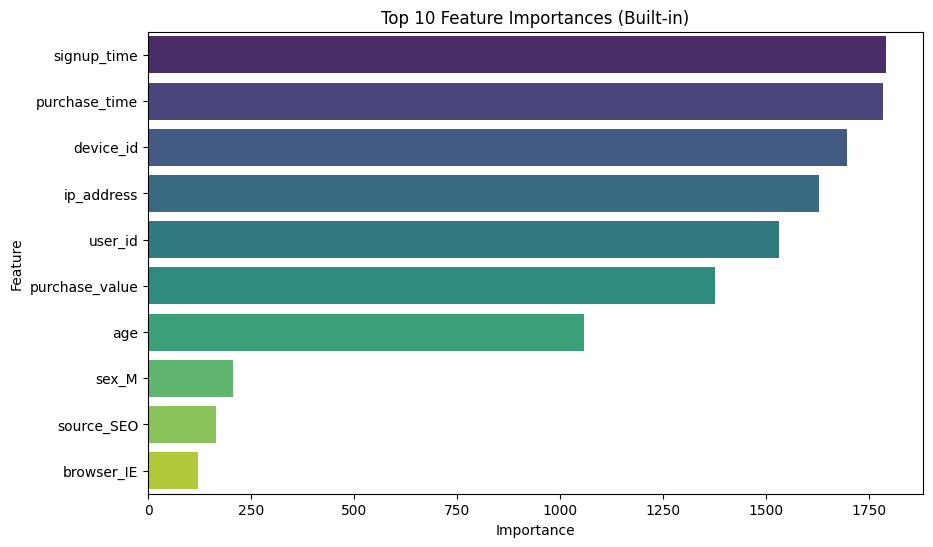

In [4]:
X_sample = X_test.sample(200, random_state=42)
y_sample = y_test.loc[X_sample.index]   # smaller batch for SHAP speed

explainer = ModelExplainability(best_model, X_test, y_test)

# Built-in importance
explainer.plot_feature_importance(top_n=10)


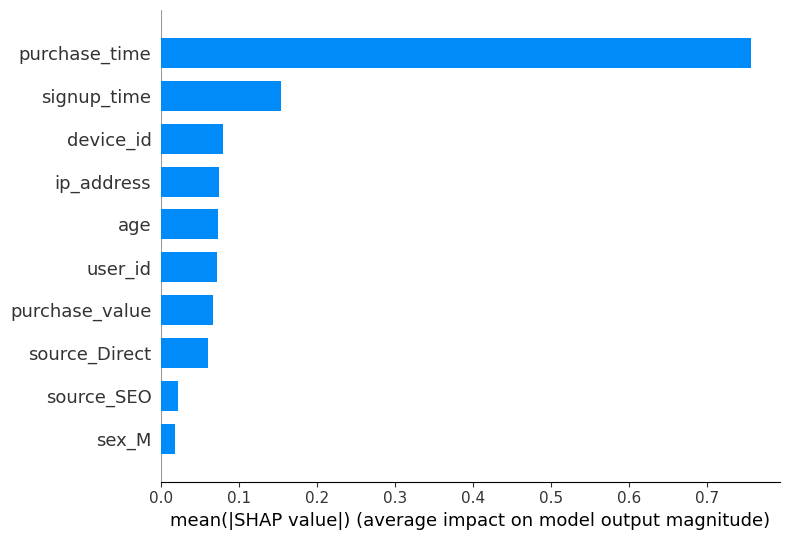

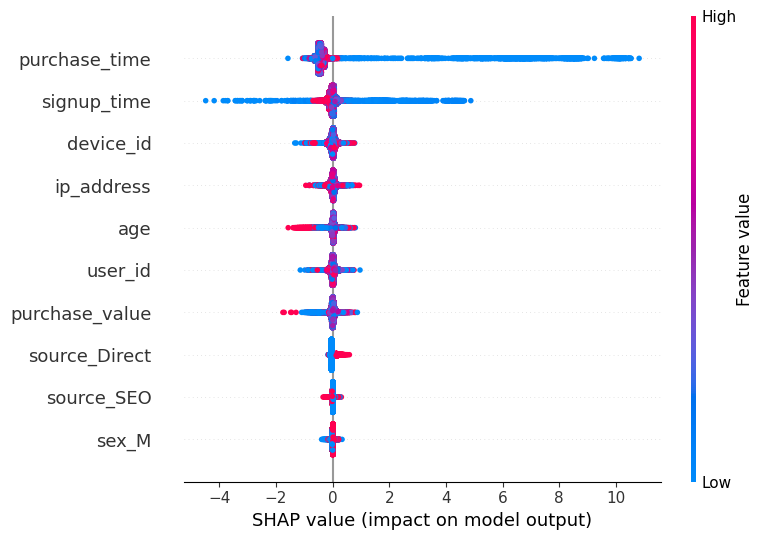

In [5]:
# 2. SHAP summary plots
explainer.plot_shap_summary(top_n=10)


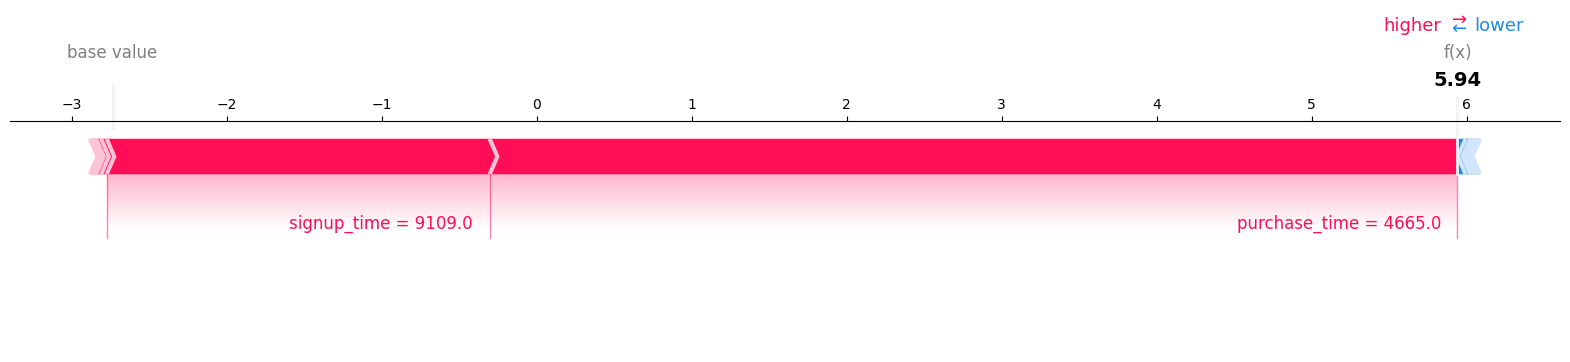

True Positive Example


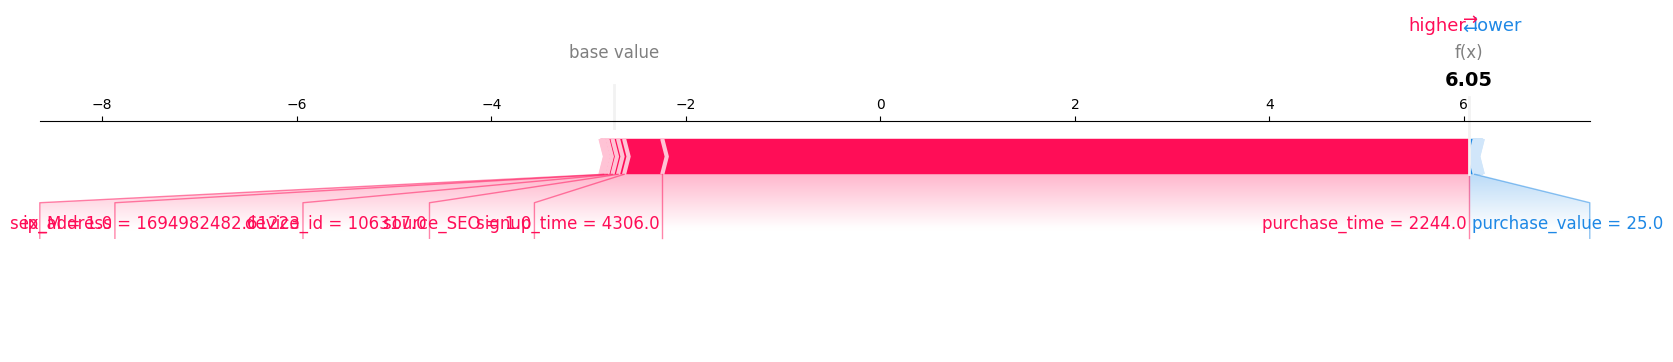

False Positive Example


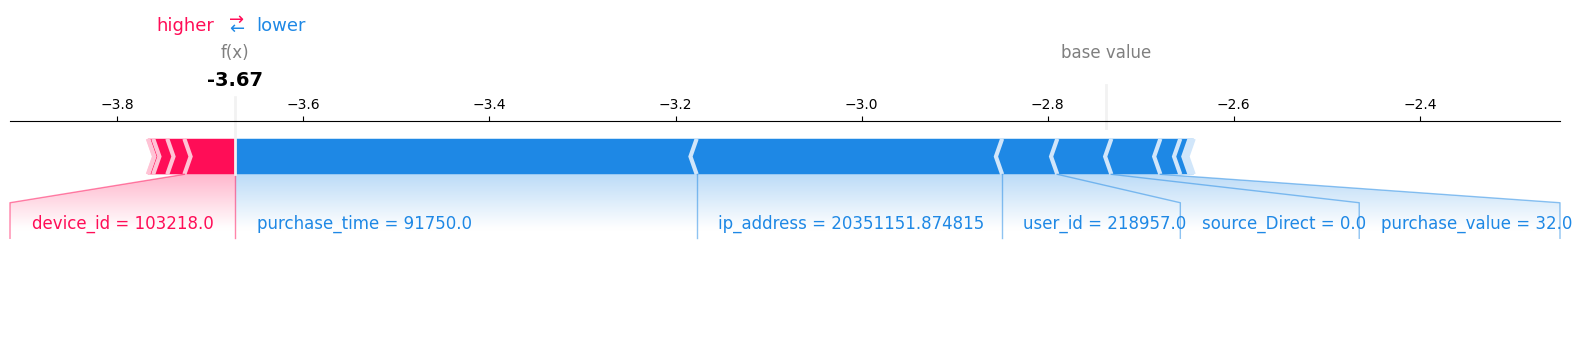

False Negative Example


In [6]:
# 3. Force plots for TP, FP, FN
explainer.plot_force_examples()

In [7]:
# 4. Get top 5 drivers
top5 = explainer.top_drivers(top_n=5)

Top 5 Drivers of Fraud Predictions (SHAP):
         Feature  SHAP Importance
2  purchase_time         0.755450
1    signup_time         0.153297
4      device_id         0.079681
6     ip_address         0.073665
5            age         0.073034


# Business Recommendations

1. Transactions within specific hours should trigger additional verification

SHAP Insight: purchase_time has the highest SHAP importance (0.755), meaning the time of purchase is the strongest predictor of fraud.

Recommendation: For transactions occurring during high-risk hours (e.g., late night or early morning), require extra verification such as OTP, email confirmation, or temporary hold for manual review.

2. Newly signed-up users require stricter monitoring

SHAP Insight: signup_time is the second most important driver (0.153), indicating that recent signups are more likely to be involved in fraud.

Recommendation: Apply limits or additional checks for accounts created within the last X hours/days, such as restricting transaction amounts, requiring two-factor authentication, or monitoring patterns closely.

3. Device and IP address monitoring for fraud detection

SHAP Insight: device_id (0.0797) and ip_address (0.0737) are key contributors. Fraudsters often use new or unusual devices/IPs.

Recommendation: Flag transactions from unrecognized devices or IP addresses. Require verification if a new device or unusual IP is used, and maintain a risk score for repeated unusual access patterns.